## <center> ECSE 415 - Intro to Computer Vision </center>
### <center> Assignment 3</center> <center> Saima Haneef - 260744058 </center>

In [2]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import random

## 1. Segmentation

### 1.1 K-Means Clustering

#### 1.1.1 Implement the K-means clustering algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for clustering

#### 1.1.2 Apply K-means to segment the image using [R,G,B] features. (R,G,B) represents color channels normalized between 0 and 1.

#### 1.1.3 Display the resulting segmented images for the first 10 iterations

In [ ]:
# read image
img = cv2.cvtColor(cv2.imread("yellowlily.png"), cv2.COLOR_BGR2RGB)
z = img.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# normalize RGB values
z = z/255.0

# Initializations
centers = [[]]
distance = []
temp = [] 
k = 2   # number of clusters

# pick random centers
for n in range(0,2):
    centers.insert(n,(z[random.randint(0, (z.shape[0])-1)]))
del centers[-1]
centers = np.array(centers)

# initialization for plotting figures
n = 0
plt.figure(figsize=(20, 20))

# For loop to display the segmented images for 10 iterations 
for m in range(0,10):
    i=0
    distance = np.array([])
    label = []
    for x in range(0, z.shape[0]):
        while(i<2):
            # find the euclidean distance for each point in relation to each center
            ans = (np.linalg.norm(z[x]-centers[i]))
            distance = np.append(distance, ans)
            i+=1

        # obtain the index with the least distance
        indx = (np.argmin(distance))

        # append the index with the least distance to the labels array
        label.append(indx)
        # reinitialize the distance array and variable i
        distance = np.array([])
        i=0

    # find mean of all points in each cluster
    for x in range(0,k):
        temp = []
        for l, i in zip(label, z):
            if l == x:
                temp.append(i)
        centers[x] = np.mean(temp, axis = 0)

    centerscopy = centers.copy()
    centerscopy = centerscopy*255.0
    center = np.array(centerscopy)
    center = np.uint8(center)
    label = np.array(label)
    label = label.transpose()
    out = center[label.flatten()]
    out = out.reshape((img.shape))
    
    # plot all images
    plt.title("Iteration " + str(m)), plt.xticks([]), plt.yticks([])

    plt.subplot(151+n%5)
    plt.imshow(out)

    n = n + 1 
    if (n%5 ==0 and n!=0):
        plt.title("Iteration " + str(m+1)), plt.xticks([]), plt.yticks([])
        plt.show()
        plt.figure(figsize=(20, 20))     

### 1.2 Expectation Maximization - Gaussian Mixture Models

#### 1.2.1 Implement the EM algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for the overall EM algorithm.

#### 1.2.2 Apply GMM to the provided image using the [R,G,B] features. (R,G,B) represents color channels normalized between 0 and 1.

#### 1.2.3 Display the resulting segmented images for the first 10 iterations.

In [65]:
def gaussianProb(z, mean, cov):
    # following the gaussian formula in the lecture slides
    # to be called in the expectation function
    arr = []
    for i in z:
        val = (i-mean)
        val = val[:, np.newaxis]
        inv = np.linalg.inv(cov)
        temp = val.T
        total = np.dot(temp,inv)
        tmp = np.dot(total,val)
        exp = math.exp(-0.5*tmp)
        prob = (1/((((2*math.pi))**(3/2))*math.sqrt(np.linalg.det(cov))))*exp
        arr.append(prob)
    return arr

def expectation(z, mean, cov, weight, label):
    # expectation function used to calculate the probability of each point
    # belonging in each cluster
    # formula used shown in lecture slides
    
    # initializations
    label = []
    arr = []
    newarr = []
    cluster1 = []
    cluster2 = []
    prob1 = []
    prob2 = []

    # calculate the gaussian probability for each point belonging to each cluster using
    # the respective mean and covariance
    # Multiply the sum of each total probability by its corresponding weight 
    # this represents the denominator in the formula shown on slide 22 of the second segmentation slides
    for i in range(0,k):
        gauss = gaussianProb(z, mean[i], cov[i])
        temp = np.sum(gauss)*weight[i]
        arr.append(temp)
    denom = np.sum(arr)

    # calculate the probability of each point belonging to each cluster and append to an array
    # newarr holds the probability of each point belonging to each cluster
    for i in range(0,k):
        gauss2 = gaussianProb(z, mean[i], cov[i])
        temp2 = (gauss2*weight[i])
        temp2 = temp2/denom
        newarr.append(temp2)
    newarr = np.array(newarr)

    # append each probability and label to its respective array depending on the higher probability of
    # each point belonging to cluster 1 or 2
    for x in range(0,newarr.shape[1]):
        if newarr[0][x]>newarr[1][x]:
            cluster1.append(z[x])
            prob1.append(newarr[0][x])
            label.append(0)
        else:
            cluster2.append(z[x])
            prob2.append(newarr[1][x])
            label.append(1)

    label = np.array(label)
    return label, prob1, prob2, cluster1, cluster2

def maximization(prob1, prob2, cluster1, cluster2):
    # maximization function is used to optimize the weight, covariance and mean values
    # the formulas used for these updates are gotten from slide 23 of the segmentation slides
    # initializations
    cov = [[]]
    weight = np.random.uniform(low=0, high=1, size=(k,1))
    mean = np.random.uniform(low=0, high=1, size=(k,3))
    
    # weight update
    weight[0] = np.sum(prob1)/len(prob1)
    weight[1] = np.sum(prob2)/len(prob2)

    # mean update
    sum1 = 0
    for x in range(0, len(cluster1)):
        val1 = cluster1[x]*prob1[x]
        sum1 = sum1 + val1
    mean[0] = sum1/np.sum(prob1)

    sum2 = 0
    for x in range(0, len(cluster2)):
        val2 = cluster2[x]*prob2[x]
        sum2 = sum2 + val2
    mean[1] = sum2/np.sum(prob2)  
    
    # covariance update
    sumcov = 0
    for x in range(0, len(cluster1)):
        val3 = cluster1[x] - mean[0]
        val3 = val3[:, np.newaxis]
        tmp = np.dot(val3,val3.T)
        tmp = tmp*prob1[x]
        sumcov = sumcov + tmp
    sumcov = sumcov/np.sum(prob1)
    cov.append(sumcov)
    
    sumcov1 = 0
    for x in range(0, len(cluster2)):
        val4 = cluster2[x] - mean[1]
        val4 = val4[:, np.newaxis]
        tmp1 = np.dot(val4,val4.T)
        tmp1 = tmp1*prob2[x]
        sumcov1 = sumcov1 + tmp1
    sumcov1 = sumcov1/np.sum(prob2)
    cov.append(sumcov1)
    cov.pop(0)
    
    return weight, mean, cov

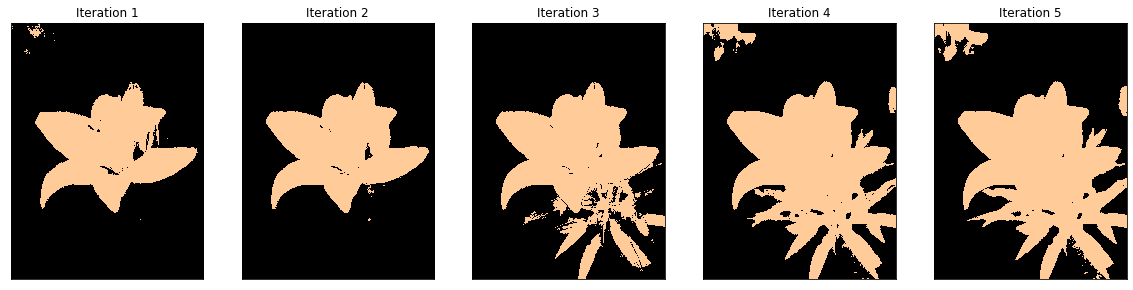

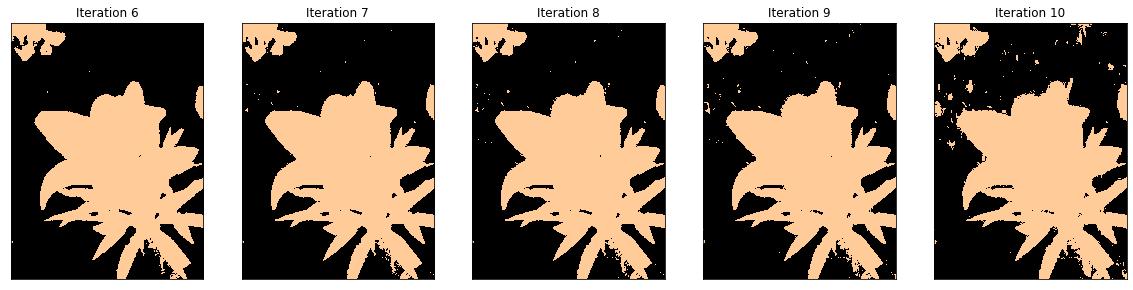

<Figure size 1440x1440 with 0 Axes>

In [66]:
# read image
img = cv2.cvtColor(cv2.imread("yellowlily.png"), cv2.COLOR_BGR2RGB)
z = img.reshape((-1,3))
z = np.float32(z)
z=z/255.0
centers = [[]]

# initialize random centers

for n in range(0,2):
    centers.insert(n,(z[random.randint(0, (z.shape[0])-1)]))
del centers[-1]
centers = np.array(centers)

# The images shown below demonstrate the EM algorithm using the random centers but it should be noted that
# random centers can sometimes result in bad initial cluster centers, so the k-means method can
# be used as a "good" approximation for initializing the centers. The commented out code below 
# is the k-means method. 
# for m in range(0,1):
#     i=0
#     distance = np.array([])
#     label = []
#     for x in range(0, z.shape[0]):
#         while(i<2):
#             # find the euclidean distance for each point in relation to each center
#             ans = (np.linalg.norm(z[x]-centers[i]))
#             distance = np.append(distance, ans)
#             i+=1

#         # obtain the index with the least distance
#         indx = (np.argmin(distance))

#         # append the index with the least distance to the labels array
#         label.append(indx)
#         # reinitialize the distance array and variable i
#         distance = np.array([])
#         i=0

#     # find mean of all points in each cluster
#     for x in range(0,k):
#         temp = []
#         for l, i in zip(label, z):
#             if l == x:
#                 temp.append(i)
#         centers[x] = np.mean(temp, axis = 0)

# initialize labels
i=0
distance = np.array([])
label = []
for x in range(0, z.shape[0]):
    while(i<2):
        ans = (np.linalg.norm(z[x]-centers[i]))
        distance = np.append(distance, ans)
        i+=1
    indx = (np.argmin(distance))
    label.append(indx)
    distance = np.array([])
    i = 0
# initializations
label = np.asarray(label)
label = label[:, np.newaxis]
mean = centers

# initialize weights as 1/k
k=2
weight = np.array([1/k, 1/k])
weight = weight[:, np.newaxis]

# initialize covariance using the mathematical formula
cov = [[]]
for y in range(0,k):
    sum = 0
    for x in range(0, label.shape[0]):
        diff = (z[x]-mean[y])
        diff = diff[:, np.newaxis]
        val = diff.T
        tmp = np.dot(diff, val)
        sum = sum + tmp
    sum = sum/(label.shape[0])
    cov.append(sum)
cov.pop(0)

# initialize plot figures
n = 0
plt.figure(figsize=(20, 20))

# perform EM algorithm for 10 iterations
for x in range(0,10):
    label, prob1, prob2, cluster1, cluster2 = expectation(z, mean, cov, weight, label) 
    weight, mean, cov = maximization(prob1, prob2, cluster1, cluster2)
    meancopy = mean.copy()
    # set colors for each cluster
    meancopy[0] = (0,0,0)
    meancopy[1] = (255,204,153)
    center = np.array(meancopy)
    center = np.uint8(meancopy)
    label = np.array(label)
    label = label.transpose()
    output = center[label.flatten()]
    output = output.reshape((img.shape))

    plt.title("Iteration " + str(x)), plt.xticks([]), plt.yticks([])
    plt.subplot(151+n%5)
    plt.imshow(output)

    n = n + 1 
    if (n%5 ==0 and n!=0):
        plt.title("Iteration " + str(x+1)), plt.xticks([]), plt.yticks([])
        plt.show()
        plt.figure(figsize=(20, 20))

### 1.3 Reasoning question

#### 1.3.1 Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

>The K-means and EM algorithms would give the same solution with spherical data distributions since the K-means algorithm works such that it assumes that the clusters are spherical. This is because the distance between the points closest to the centroids are minimized through this algorithm. Consequently, to have the same solution, the data points need to be distributed evenly, so that the EM algorithm can also follow through with the K-means algorithm. Specifically, since the EM algorithm also looks at the weights and covariance in addition to the mean (which is used in K-means), the weights and covariance would have to be invariant leading to spherical data distributions.

## 2. Stereo Vision - Epipolar Geometry 

#### 2.1 Compute matching SIFT keypoints from a stereo image pair

#### 2.2 Compute and display the epipolar lines for both images

In [67]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2, y0, y1, x0, x1

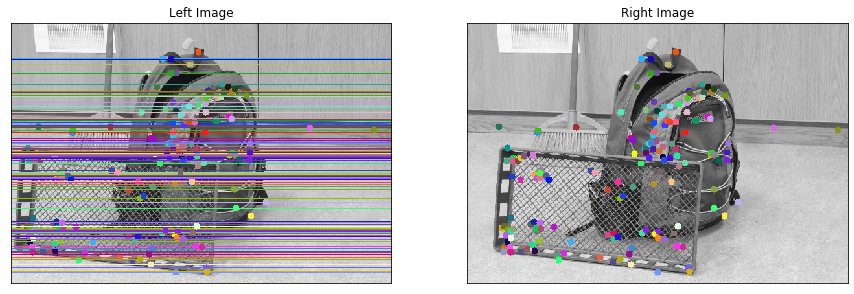

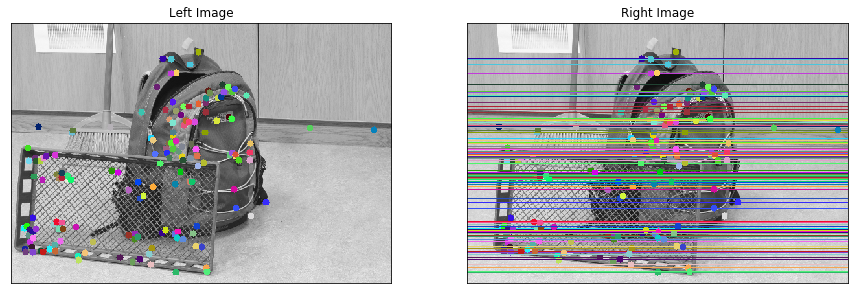

In [96]:
# read images
imgR = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)
imgL = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)

# lower the dimensions of the original image (original image is too large)
newX,newY = imgR.shape[1]*0.2, imgR.shape[0]*0.2
imgR = cv2.resize(imgR,(int(newX),int(newY)))
newX,newY = imgL.shape[1]*0.2, imgL.shape[0]*0.2
imgL = cv2.resize(imgL,(int(newX),int(newY)))

imgr = imgR.copy()
imgl = imgL.copy()

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2) # query image, train image

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 
# epipolar line in Right image = F ptsL (matrix multiplication)
# epipolar line in Left image = F' ptsR (matrix multiplication)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1, y0, y1, x0, x1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2, y0, y1, x0, x1 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### 2.3 Pick any one keypoint in the left image which has a correct match in the right image, and is on the corresponding epipolar line. Extract a patch of size (5 × 5) around this keypoint in the left image.

[ 46 353]


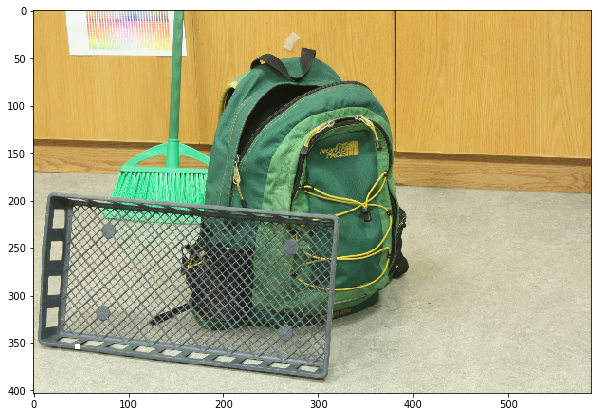

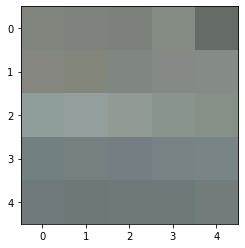

In [97]:
# read left image
imgl = cv2.cvtColor(cv2.imread("im1.png"), cv2.COLOR_BGR2RGB)

# resize image
newX,newY = imgl.shape[1]*0.2, imgl.shape[0]*0.2
imgl = cv2.resize(imgl,(int(newX),int(newY)))

copyleft = imgl.copy()

# pick a keypoint
point = ptsL[20]

# print keypoint
print(point)

# extract 5x5 patch 
window = copyleft[point[1]-2:point[1]+3, point[0]-2:point[0]+3]

plt.figure(figsize=(10,10))

# depict the 5x5 patch on the left image
finalimg = cv2.rectangle(imgl, (point[0]-2, point[1]-2), (point[0]+3, point[1]+3), (255,255,255), -1) 
plt.imshow(finalimg)
plt.show()

# plot 5x5 patch
plt.imshow(window)
plt.show()

#### 2.4 Match the extracted patch to every 5 × 5 patch along the corresponding epipolar line in the right image. Use normalized cross correlation metric for matching.

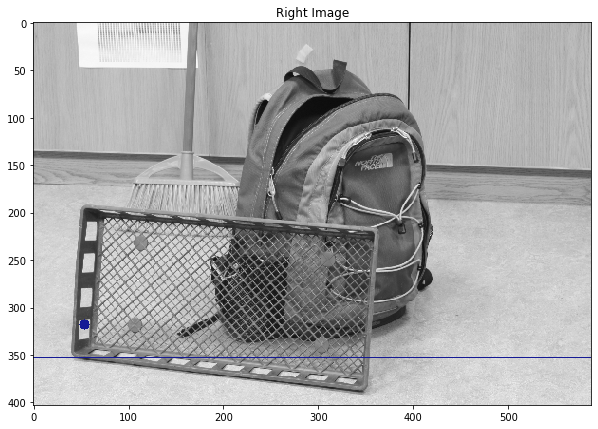

In [99]:
# read images
imgR = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)
imgL = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)

# lower the dimensions of the original image (original image is too large)
newX,newY = imgR.shape[1]*0.2, imgR.shape[0]*0.2
imgR = cv2.resize(imgR,(int(newX),int(newY)))
newX,newY = imgL.shape[1]*0.2, imgL.shape[0]*0.2
imgL = cv2.resize(imgL,(int(newX),int(newY)))

# copy the image
right = imgR.copy()

# find corresponding epiline of chosen keypoint
val = np.reshape(point, (-1,2))
epilineR = cv2.computeCorrespondEpilines(val, 1, F)
epilineR = np.reshape(epilineR,(-1,3))

# using the drawlines function, return the y intercept (along with the x starting and ending points)
imgR2, imgL2, y0, y1, x0, x1 = drawlines(imgR, imgL, epilineR, ptsR, ptsL)

plt.figure(figsize=(10,10))
plt.imshow(imgR2, cmap="gray")
plt.title("Right Image")
plt.show()

In [100]:
# read right image
imgR = cv2.imread("im0.png")
# resize image
newX,newY = imgR.shape[1]*0.2, imgR.shape[0]*0.2
imgR = cv2.resize(imgR,(int(newX),int(newY)))
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# crop the area of the right image that lines up with the epipolar line
# this is done by returning the y intercept from the drawlines function and cropping that
# area of the right image to the window or 5x5 patch from the left image
rightPatch = imgR[y0-2:y0+3, x0:x1]

# the following code was taken from Tutorial 4
img_disp = rightPatch.copy()

ht, wt = window.shape[0:2]

# matchtemplate is used to compare the long strip of the right image with the 5x5 patch
# this function works such that each 5x5 patch of the right strip is compared with the 5x5 window from
# the left image
res = cv2.matchTemplate(rightPatch, window, cv2.TM_CCOEFF_NORMED)

# set a threshold (need to tune it)
thres = 0.9
# find all points above threshold
loc = np.where(res >= thres)

# loop though the points
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_disp, pt, (pt[0]+wt, pt[1]+ht), (255,255,0), 5)

#### 2.5 Plot normalized cross correlation values (on y-axis) against index of the patch in the left image (on x-axis)(refer Lecture 13 slide 57). Find the matching point with maximum normalized cross correlation value. Display found matching points in both the images.

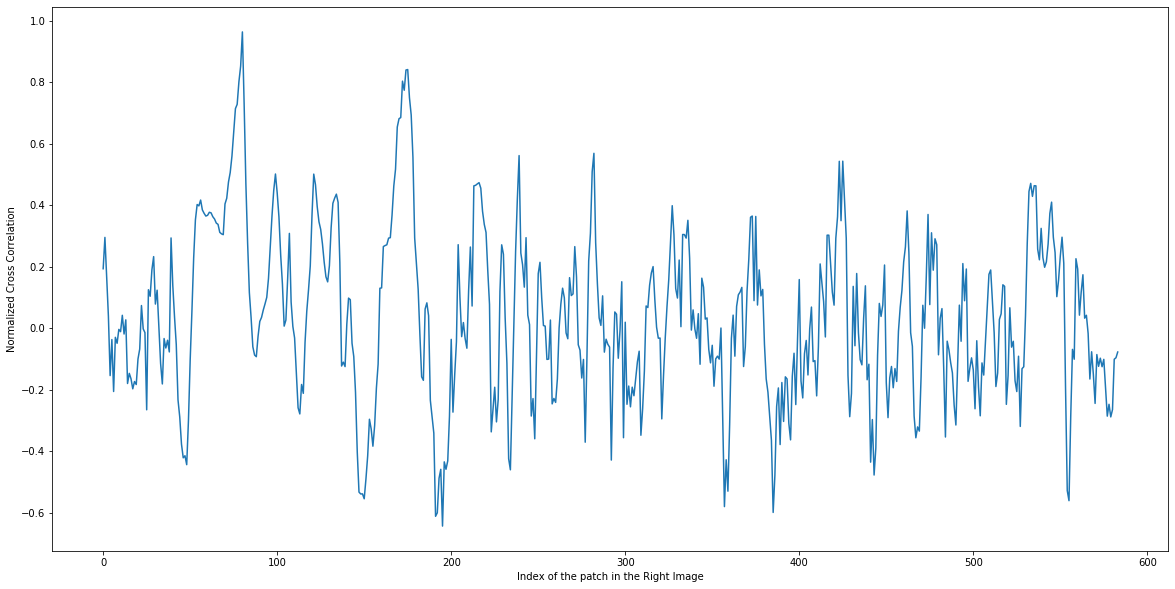

(0, 80)


In [101]:
# Normalized cross correlation values
res = res.T
res = res.tolist()
# index of the patch moving across on the x-axis
indx = []
for i in range(x0, x1):
    indx.append(i)

plt.figure(figsize = (20,10))
plt.plot(arr, res)
plt.xlabel("Index of the patch in the Right Image")
plt.ylabel("Normalized Cross Correlation")
plt.show()

# To check the matching point with the maximum normalized cross correlation value
# print maximum location value in the graph
res = np.array(res)
_, _, low, high = cv2.minMaxLoc(res)
print(high)
# the maximum value matches the location of the matching point

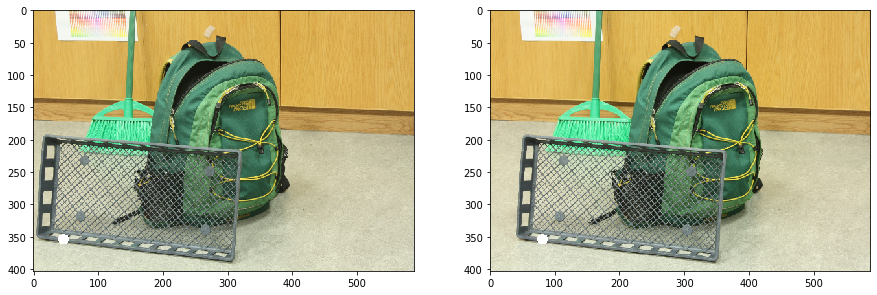

In [102]:
# read image
imgl = cv2.cvtColor(cv2.imread("im1.png"), cv2.COLOR_BGR2RGB)

# resize image
newX,newY = imgl.shape[1]*0.2, imgl.shape[0]*0.2
imgl = cv2.resize(imgl,(int(newX),int(newY)))

# read image
imgr = cv2.cvtColor(cv2.imread("im0.png"), cv2.COLOR_BGR2RGB)
# resize image
newX,newY = imgr.shape[1]*0.2, imgr.shape[0]*0.2
imgr = cv2.resize(imgr,(int(newX),int(newY)))

# display matching point
plt.figure(figsize=(15,15))
tmp1 = cv2.rectangle(imgl, (point[0]-2, point[1]-2), (point[0]+3, point[1]+3), (255,255,255), 10) 
plt.subplot(121), plt.imshow(tmp1)
tmp2 = cv2.rectangle(imgr, (high[1]-2, y0-2), (high[1]+3, y0+3), (255,255,255), 10) 
plt.subplot(122), plt.imshow(tmp2)
plt.show()


#### 2.6 Did you find exactly one matching point or multiple matches? Is the matching point you found the correct one? Explain

>As shown above, one matching point was found and this point matches correctly as is visible above by the white patches. This was done using the cv2 function matchTemplate which looks for a specific part of an image using a template image. A random keypoint was then chosen (using SIFT) and after finding its corresponding epipolar line in the right image, the y intercept of that particular line was found. After finding this y intercept value (using the drawlines method from the tutorial), a long patch surrounding the epipolar line was extracted and as such, using the cv2 function matchTemplate which slides the 5x5 window patch through the longer extracted patch to find the right match using the normalized cross correlation method as specified.  

## 3. Motion Algorithm - Multi-resolution LucasKanade optical flow estimation

#### 3.1 Extract good points to track from ‘frame1.png’ using the Harris corner detector. Use the openCV function goodFeaturesToTrack and set the parameter value maxCorners=500. Search for the optimal values for the parameters qualityLevel, minDistance, blockSize

#### 3.2 Compute the optical flow between ‘frame1.png’ and ‘frame2.png’ for the above detected points. Use the openCV function calcOpticalFlowPyrLK. Set winSize=10, TERM CRITERIA EPS=0.03 and TERM CRITERIA COUNT=10. Experiment with the maximum pyramid level by variying maxLevel parameter from 0 to 10. For each pyramid level, compute the mean of the tracking error returned by calcOpticalFlowPyrLK function for points whose correspondence search is successful. 

#### 3.3 Display the optical flow for each setting of maximum pyramid level. Comment on the quality of the results. 

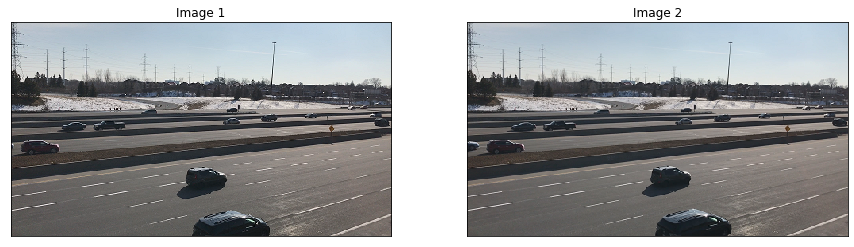

<Figure size 1080x1080 with 0 Axes>

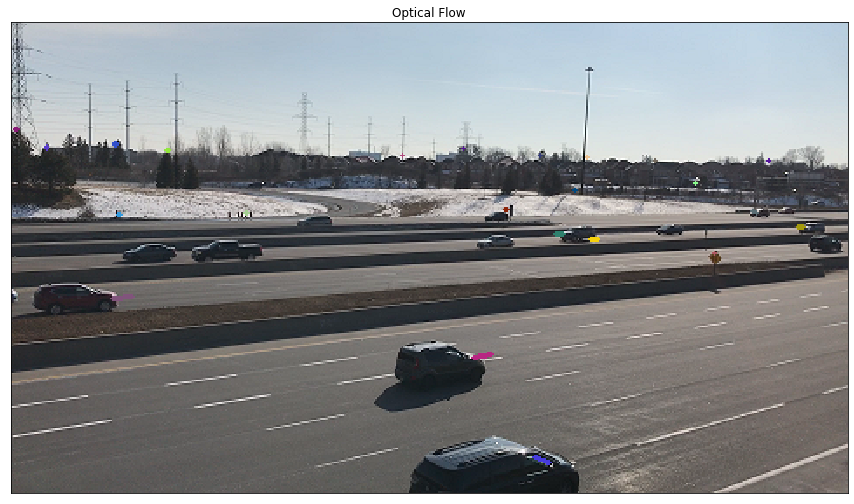

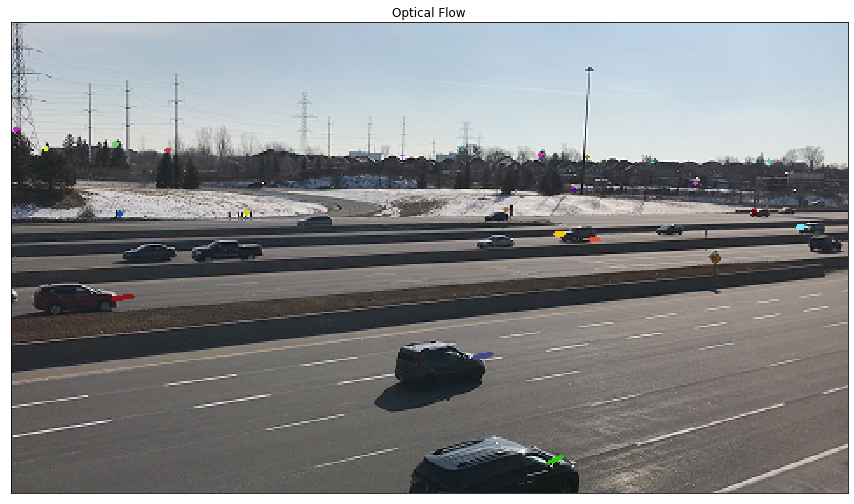

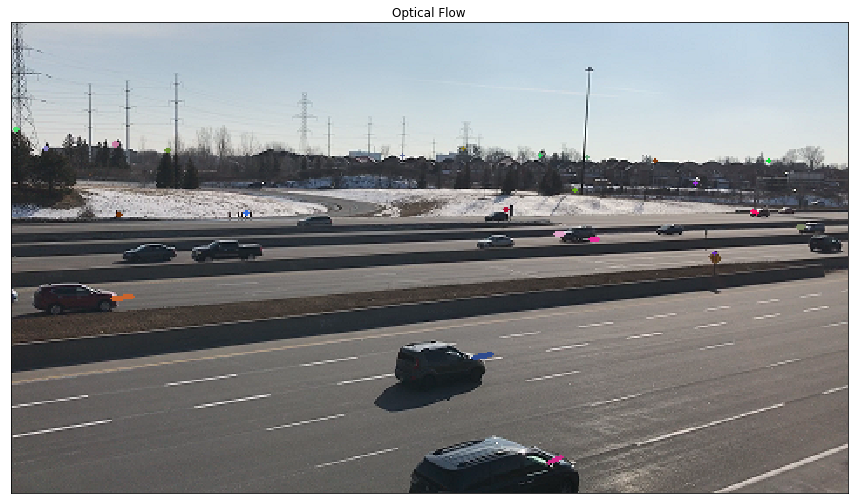

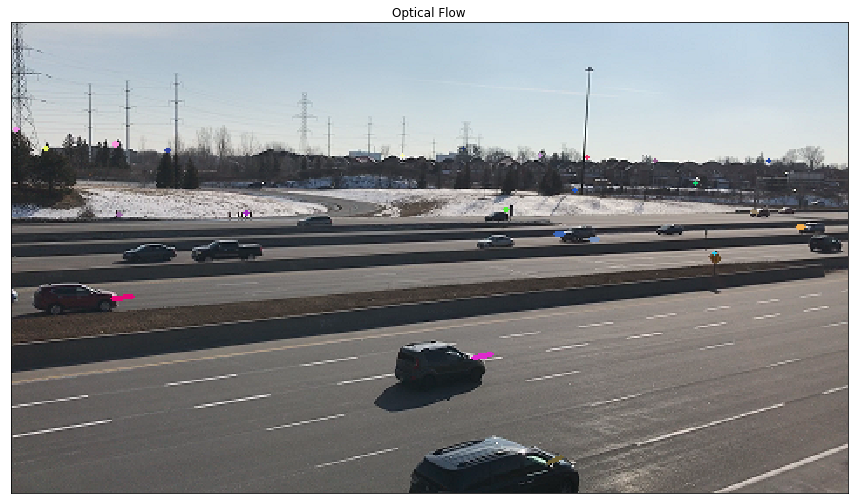

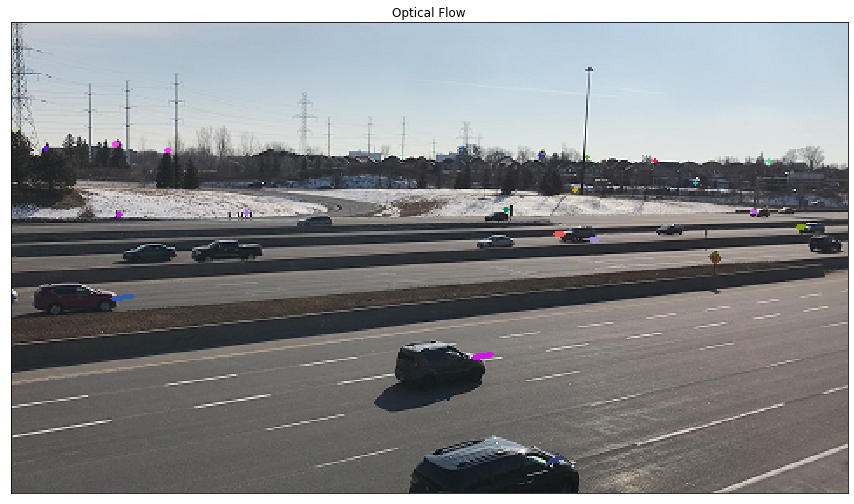

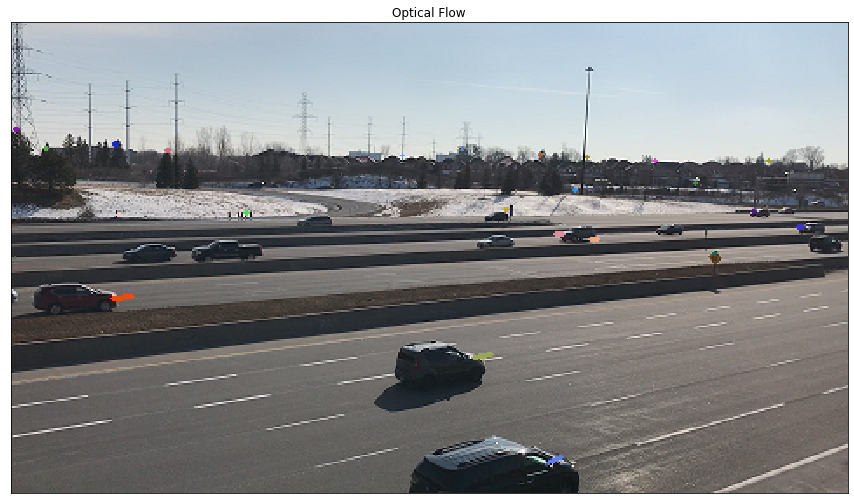

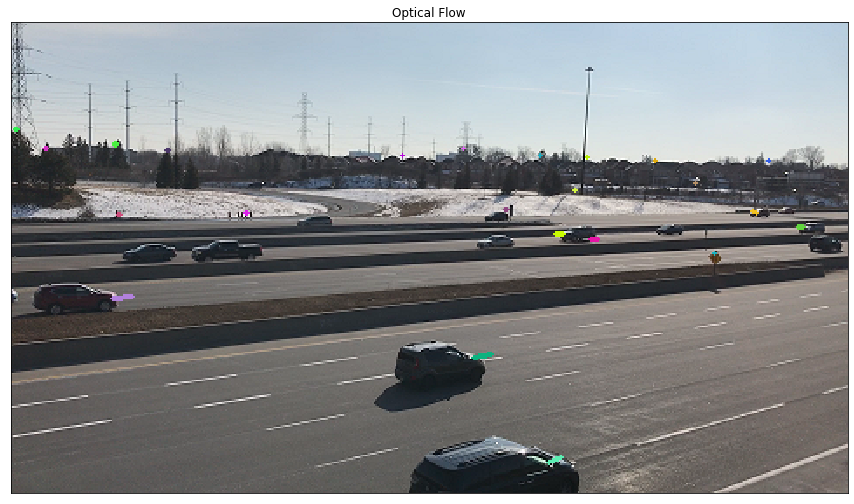

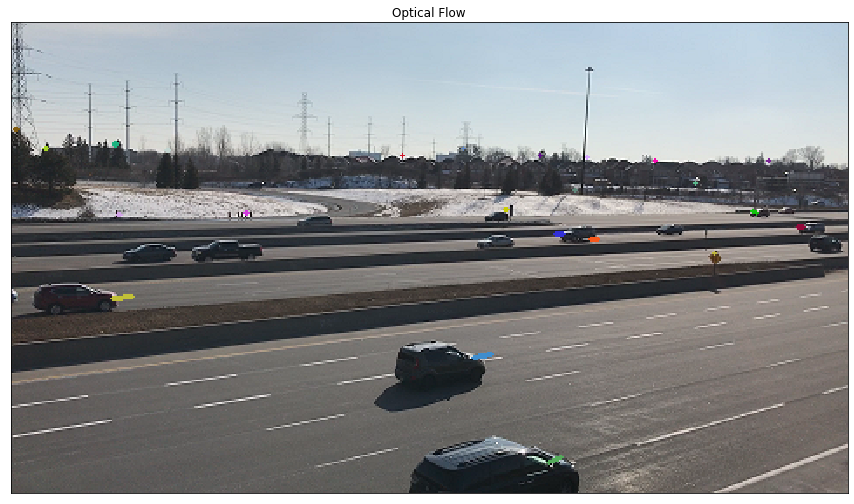

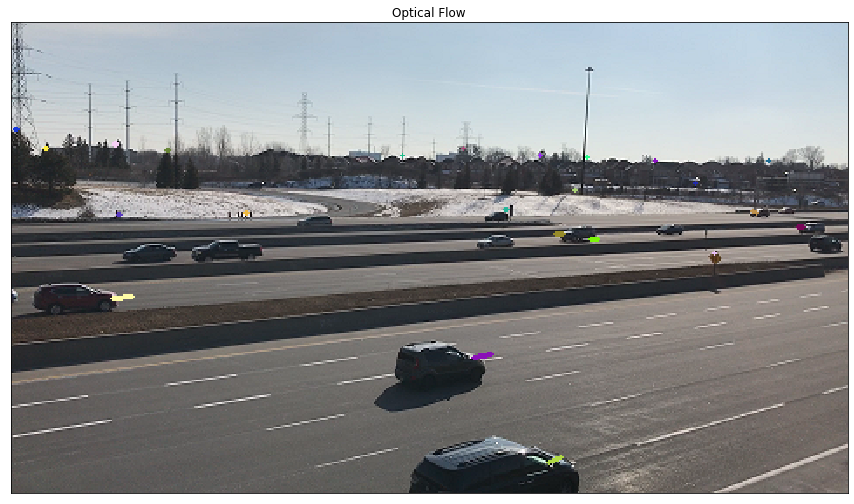

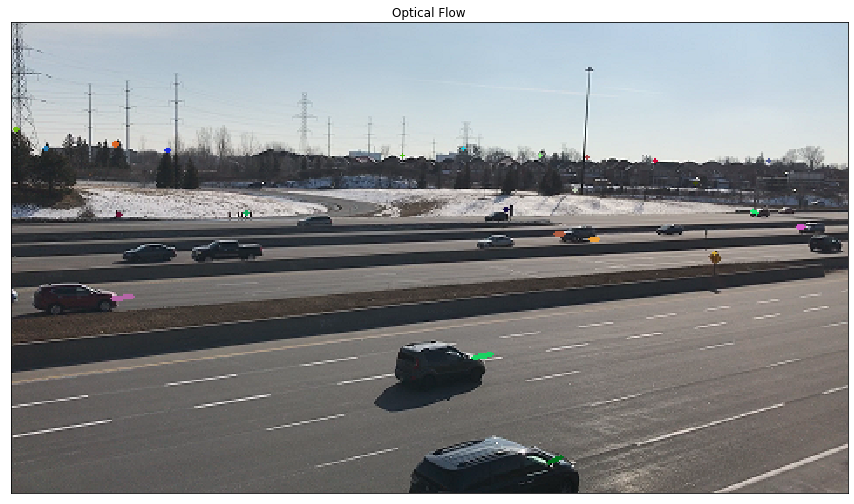

In [3]:
# read images
img1 = cv2.imread("frame1.png")
img2 = cv2.imread("frame2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 20, # 40
                       blockSize = 7 ) # 5
level = []
mean = []

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
    
for x in range(1,11):
# parameters for lucas kanade optical flow
    lk_params = dict( winSize = (10,10),
                      maxLevel = x,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                                 10, 0.03))

    # find good corners in the first image
    p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params, useHarrisDetector = True)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    
    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    mean.append(np.mean(err[st==1]))
    level.append(x)
    # create some random colors
    color = np.random.randint(0, 255, (good_new.shape[0], 3))

    # create a mask image for drawing purposes
    mask = img1.copy()

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

    # display images
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
    plt.show()


> As can be seen in the optical flow diagrams shown above, the diagrams remain consistent as the max pyramid level is altered. Overall, the images display the optical flow of moving objects like the cars but still consist of points on the trees in the background. While altering the parameters, it was observed that increasing the quality level resulted in less points since this parameter is responsible for discarding points less than quality level times the pixel value. A minmum distance more than 7 was also seen as more favorable in terms of seeing better results. It can be observed that with a max pyramid level of 1, there are more points on the trees but these decrease when the max pyramid level is increased to 2. After pyramid level of 2, the images remain constant. 

#### 3.4 Plot the mean of the error (on y-axis) vs. pyramid level (on x-axis). Discuss the trends you observe in the plot.

[5.1558557, 4.076549, 4.075258, 4.0754075, 4.0754075, 4.0754075, 4.0754075, 4.0754075, 4.0754075, 4.0754075]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Text(0, 0.5, 'Mean of the Error')

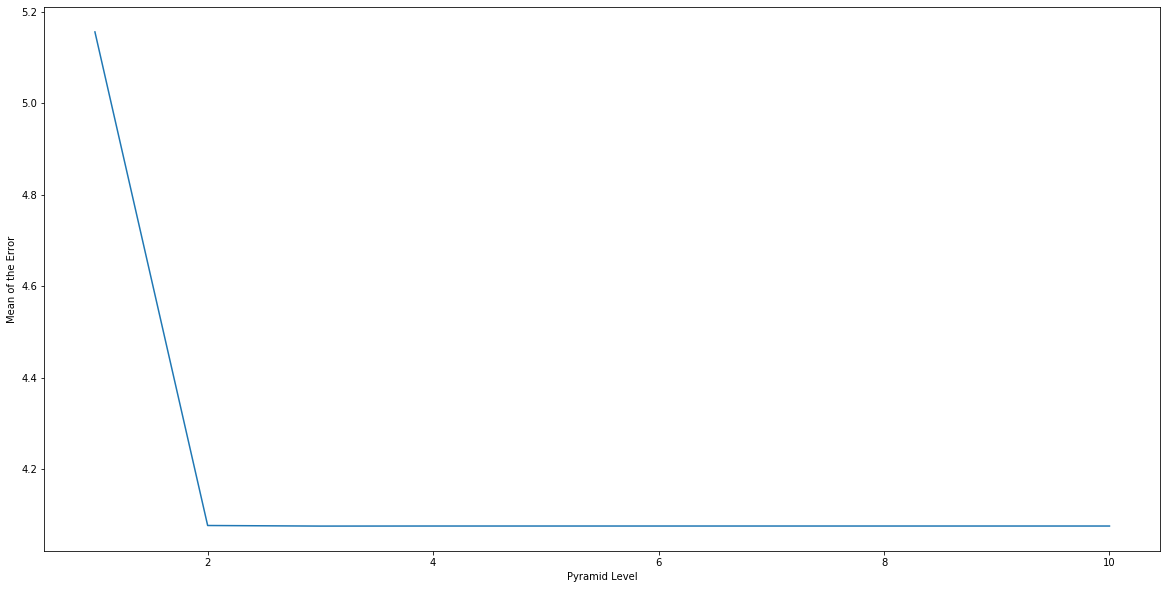

In [4]:
plt.figure(figsize = (20,10))
plt.plot(level, mean)
plt.xlabel("Pyramid Level")
plt.ylabel("Mean of the Error")

> As can be seen in the plot above, the mean of the error decreases considerably after the max pyramid level is set to 2 and stays constant from a pyramid level of 2 to 10 inclusive. This can also be seen in the optical flow diagrams which remain consistently the same.